<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-loan-approval-prediction-s4e10?scriptVersionId=199060971" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">Loan Approval Prediction</span>
## <span style="border: solid gold 3px; background-color: #B58050; color: white; padding: 3px">Playground Series - Season 4, Episode 10

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


![](https://www.kaggle.com/competitions/84894/images/header)

#### <span style="color: #B58050">version 1</span> - first glance at the data, without EDA
#### <span style="color: #B58050">version 2</span> - I found outliers in "person_emp_length" feature
#### <span style="color: #B58050">version 3</span> - Added pie plot visualization to categorical features
#### <span style="color: #B58050">version 4</span> - Added pivot tables, histograms and some other things
#### <span style="color: #B58050">version 5</span> - Build heatmap and convert categorical variables into dummy
#### <span style="color: #B58050">version 6</span> - I planed to train 3 models (LR, SVM and KNN) and also created base for optuna tuning on CatBoost
#### <span style="color: #B58050">version 7</span> - Catboost with CV (40 trials)

## 🪙 <span style="color: #B58050">Starting from this competition I will return to daily activity on kaggle because I need to become a strong professional in machine learning and data science. I hope this notebook will be the best among my previous ones and my results at the end of the competition will be good!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 'id' feature is index
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col=0)

In [4]:
# Display all features in DataFrame
pd.set_option('display.max_columns', None)

In [5]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
train.tail(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0
58644,31,75000,MORTGAGE,2.0,VENTURE,B,15000,11.11,0.20,N,5,0


<a id="features"></a>
    
#### - <span style="color: #B58050">person_age</span>: Age of the person applying for the loan, measured in years.
#### - <span style="color: #B58050">person_income</span>: Annual income of the applicant in dollars.
#### - <span style="color: #B58050">person_home_ownership</span>: Type of home ownership (e.g., RENT, MORTGAGE, OWN).
#### - <span style="color: #B58050">person_emp_length</span> Length of employment in years (for whole life maybe).
#### - <span style="color: #B58050">loan_intent</span>: Purpose of the loan (e.g., EDUCATION, VENTURE, PERSONAL).
#### - <span style="color: #B58050">loan_grade</span>: Assigned grade to the loan indicating its risk profile (e.g., A is the best).
#### - <span style="color: #B58050">loan_amnt</span>: Amount of money requested by the applicant for the loan.
#### - <span style="color: #B58050">loan_int_rate</span>: Annual interest rate of the loan, shown as a percentage.
#### - <span style="color: #B58050">loan_percent_income</span>: Ratio of the loan amount to the applicant's annual income.
#### - <span style="color: #B58050">cb_person_default_on_file</span>: Indicator of whether the person has a history of defaulting on other credit obligations (Y for Yes, N for No).
#### - <span style="color: #B58050">cb_person_cred_hist_length</span>: Length of the applicant's credit history, measured in years.
#### - <span style="color: #B58050">loan_status</span>: Status of the loan (1 if defaulted, 0 if not).

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">EDA

In [7]:
# For visualization purposes
numeric = ['person_age', 'person_income', 'person_emp_length', 'loat_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [8]:
train.shape

(58645, 12)

### <span style="color: #B58050">There are 12 features (one of them is target) and about 59K observations

In [9]:
test.shape

(39098, 11)

![](https://images.ctfassets.net/1aemqu6a6t65/5rPsNLkgpwvZPSmjhE5ChB/9ee0978b3d792515d59fefab5296b832/wall-street-photo-tagger-yancey-iv-nyc-and-company-02-2?w=1200&h=800&q=75)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


### <span style="color: #B58050">At first glance, there are no gaps in the data.

In [11]:
train.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [12]:
test.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### <span style="color: #B58050">Yes, there are no gaps in the data.

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


### [Description of the features](#features)

### <span style="color: #B58050">About 3/4 of borrowers are people in age not above than 30. 75% of sample has income below 76k$.</span>
# <span style="color: #B58050">I also guess that observation where person_age is 123 and person_emp_length is also 123 is anomaly, so don't forget to clear the data!

### My post about this: [🤔 Anomaly or what does means ''person_emp_length'' feature?](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536990)

# 🪙 <span style="color: #B58050">Outliers detection

In [14]:
# How many years people didn't work
years_without_work = train['person_age'] - train['person_emp_length']
years_without_work.sort_values(ascending=True).head(30)

id
49252   -102.0
41079    -95.0
41912      2.0
26125      2.0
43518      6.0
746        6.0
52038      7.0
24214      8.0
32236      8.0
58602      9.0
18783      9.0
56176      9.0
33012     10.0
699       11.0
12638     11.0
17542     11.0
34852     12.0
48915     12.0
16378     12.0
3072      12.0
48118     12.0
53992     12.0
17861     12.0
15921     13.0
20615     13.0
8222      13.0
18293     13.0
48185     13.0
47532     14.0
52901     14.0
dtype: float64

In [15]:
train.iloc[[49252, 41079]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1


In [16]:
outliers_indexes = years_without_work.sort_values(ascending=True).head(28).index
outliers_indexes

Index([49252, 41079, 41912, 26125, 43518,   746, 52038, 24214, 32236, 58602,
       18783, 56176, 33012,   699, 12638, 17542, 34852, 48915, 16378,  3072,
       48118, 53992, 17861, 15921, 20615,  8222, 18293, 48185],
      dtype='int64', name='id')

In [17]:
train.iloc[outliers_indexes]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
41912,23,48686,RENT,21.0,EDUCATION,B,12000,11.86,0.25,N,2,0
26125,43,56000,RENT,41.0,HOMEIMPROVEMENT,B,2000,10.99,0.04,N,14,0
43518,25,42000,RENT,19.0,MEDICAL,C,6000,13.49,0.14,N,4,0
746,23,100000,MORTGAGE,17.0,PERSONAL,A,17000,7.49,0.17,N,3,0
52038,38,42000,MORTGAGE,31.0,VENTURE,B,11000,11.49,0.26,N,14,0
24214,43,50000,RENT,35.0,DEBTCONSOLIDATION,A,9000,5.42,0.18,N,16,0
32236,23,25596,RENT,15.0,EDUCATION,A,5000,7.90,0.20,N,4,0


### <span style="color: #B58050">I don't know at what age people in the US or other countries can start working, but I'm guessing that the 28 observations above are outliers, since their years_out_of_work are less than 14 years.

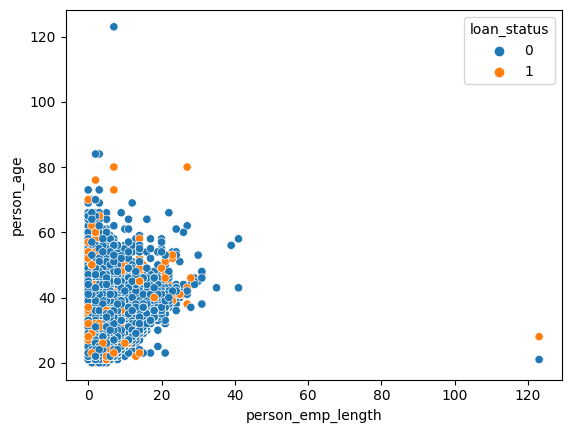

In [18]:
# Visualize outliers
sns.scatterplot(x=train['person_emp_length'], y=train['person_age'], hue=train['loan_status']);

### <span style="color: #B58050">We see that at least there are 3 outliers. But age 123 might be real age of really old person. Anyway I guess that this observation is also outlier because of number 123.

In [19]:
outliers = train.loc[(train['person_emp_length'] > 50) | (train['person_age'] > 90)]
outliers

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0


In [20]:
print(train.shape)
train = train.drop(outliers.index)
train.shape

(58645, 12)


(58642, 12)

### <span style="color: #B58050">Outliers are now removed

![](https://banker.bg/wp-content/uploads/56b0e1f0-d857-4db4-86c1-92f575d5dde5-4.jpg)

In [21]:
train.describe(include=['object']).T

,count,unique,top,freq
person_home_ownership,58642,4,RENT,30594
loan_intent,58642,6,EDUCATION,12271
loan_grade,58642,7,A,20984
cb_person_default_on_file,58642,2,N,49941


## <span style="color: #B58050">Value counts for each categorical feature

In [22]:
for index, feature in enumerate(categorical):
    print(train[feature].value_counts(), end='\n\n')
    
    if index != len(categorical) - 1:  # Margins
        print('-' * 100)
        print()

person_home_ownership
RENT        30594
MORTGAGE    24821
OWN          3138
OTHER          89
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

loan_intent
EDUCATION            12271
MEDICAL              10933
PERSONAL             10015
VENTURE              10010
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

loan_grade
A    20984
B    20398
C    11036
D     5033
E     1009
F      149
G       33
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

cb_person_default_on_file
N    49941
Y     8701
Name: count, dtype: int64



In [23]:
for index, feature in enumerate(categorical):
    print(train[feature].value_counts(normalize=True), end='\n\n')
    
    if index != len(categorical) - 1:  # Margins
        print('-' * 100)
        print()

person_home_ownership
RENT        0.521708
MORTGAGE    0.423263
OWN         0.053511
OTHER       0.001518
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

loan_intent
EDUCATION            0.209253
MEDICAL              0.186436
PERSONAL             0.170782
VENTURE              0.170697
DEBTCONSOLIDATION    0.155742
HOMEIMPROVEMENT      0.107090
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

loan_grade
A    0.357832
B    0.347839
C    0.188193
D    0.085826
E    0.017206
F    0.002541
G    0.000563
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

cb_person_default_on_file
N    0.851625
Y    0.148375
Name: proportion, dtype: float64



### <span style="color: #B58050">Only 5% of people who would like to borrow money have own real estate(s). Most frequent loan intention is for education purposes (21%)

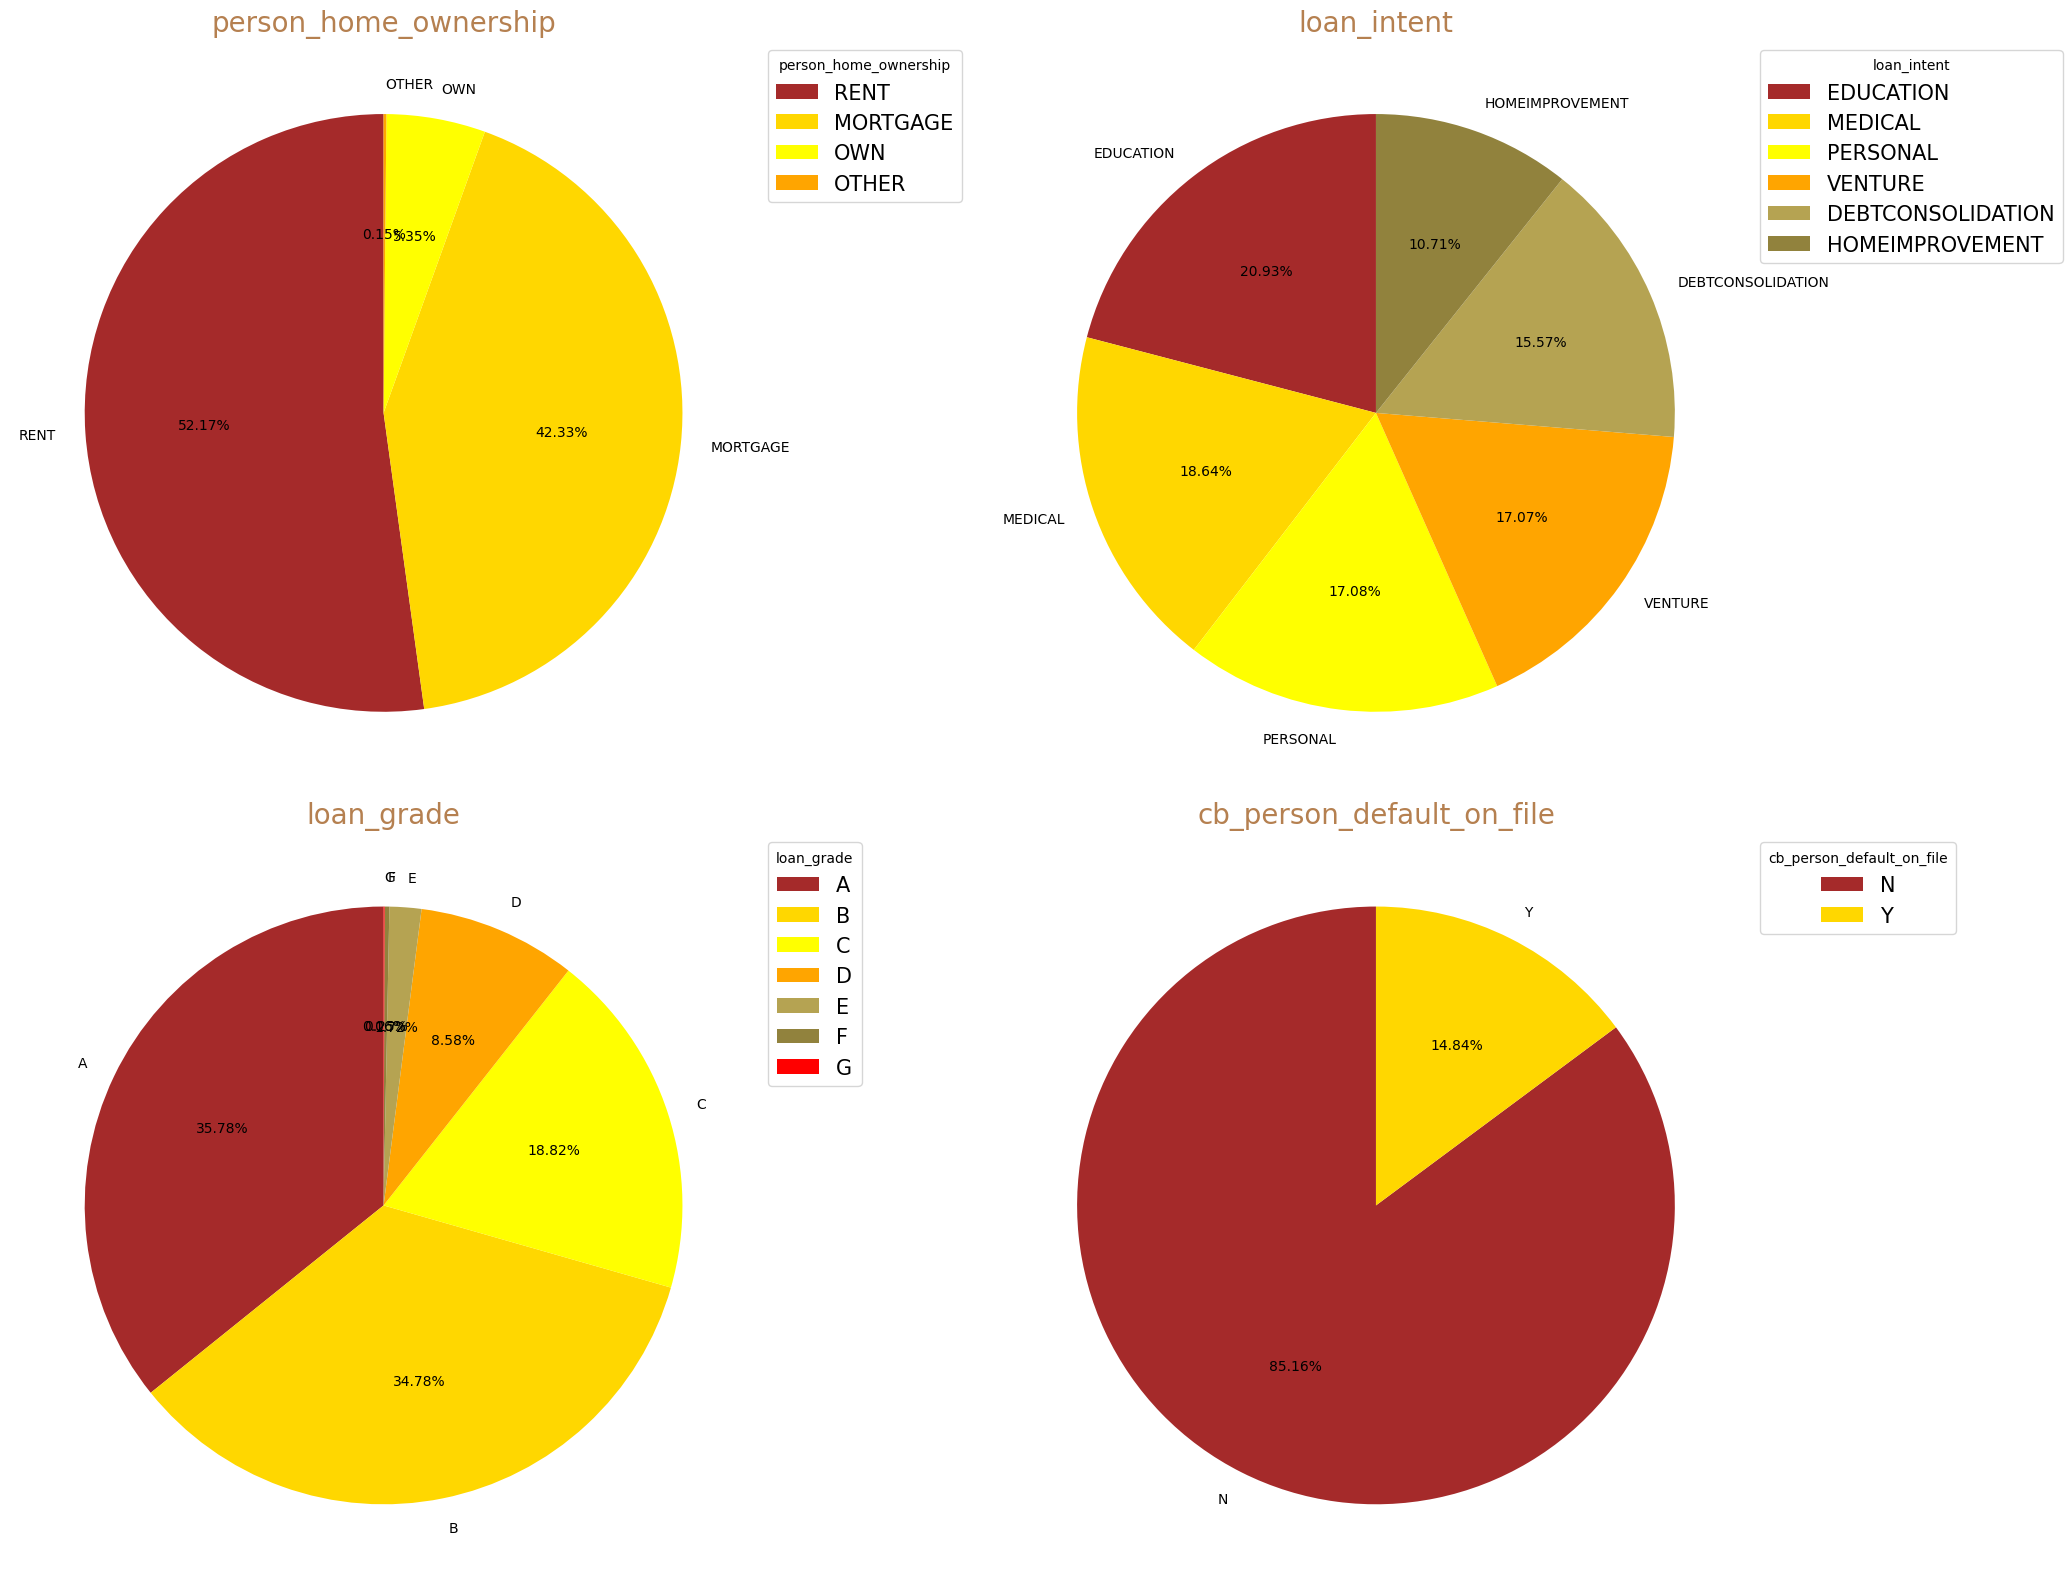

In [24]:
colors = ['brown', 'gold', 'yellow', 'orange', '#B5A352', '#91823D', 'red']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 16))

for index, feature in enumerate(categorical):
    label_count = train[feature].value_counts()
    row, col = divmod(index, 2)
    
    wedges, texts, autotexts = axes[row, col].pie(
        x=label_count, 
        labels=label_count.index, 
        autopct='%1.2f%%',
        startangle=90, 
        colors=colors,
    )
    
    axes[row, col].set_title(feature, color='#B58050', fontsize=20)
    
    axes[row, col].legend(
        wedges, 
        label_count.index, 
        title = feature, 
        loc = "upper left", 
        bbox_to_anchor = (1, 0, 0.5, 1), 
        fontsize = 15
    )

plt.tight_layout()
plt.show()

## <span style="color: #B58050">Desine some pivot tables to analyse the data

In [25]:
pd.pivot_table(data=train, values='person_age', index='loan_grade', columns='person_home_ownership', aggfunc='count', fill_value=0)

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_grade,,,,
A,11575,21,1144,8244
B,7887,40,1065,11406
C,3471,16,583,6966
D,1507,10,300,3216
E,326,1,36,646
F,49,0,8,92
G,6,1,2,24


### <span style="color: #B58050">Most people who has loan_grade equals to A has mortgage and people who has loan_grade equals to B rent real estates

In [26]:
pd.pivot_table(data=train, values='person_age', index='loan_intent', columns='person_home_ownership', aggfunc='count')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_intent,,,,
DEBTCONSOLIDATION,4045,10,43,5035
EDUCATION,5002,17,695,6557
HOMEIMPROVEMENT,3245,10,370,2655
MEDICAL,3824,7,468,6634
PERSONAL,4466,23,560,4966
VENTURE,4239,22,1002,4747


## <span style="color: #B58050">Build histogram of distribution

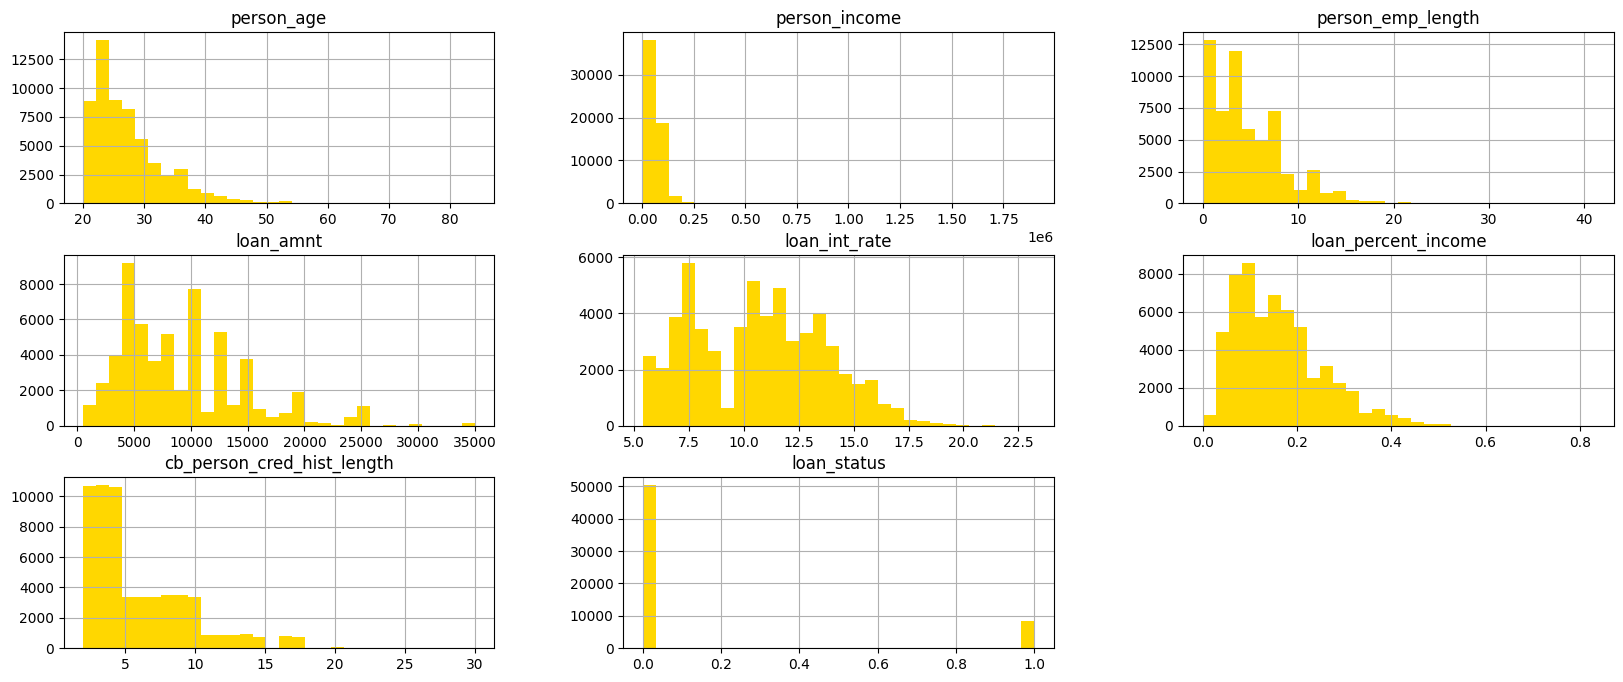

In [27]:
train.hist(figsize=(20, 8), color='gold', bins=30);

### <span style="color: #B58050">The distribution is strongly skewed to the left: most observations are concentrated in the 20-40 year range. Most people have less than 10 years of experience.

In [28]:
train = pd.get_dummies(data=train, drop_first=True)
test = pd.get_dummies(data=test, drop_first=True)

train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False
1,22,56000,6.0,4000,13.35,0.07,2,0,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False
2,29,28800,8.0,6000,8.90,0.21,10,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
3,30,70000,14.0,12000,11.11,0.17,5,0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
4,22,60000,2.0,6000,6.92,0.10,3,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False


## <span style="color: #B58050">Convert boolean values to numeric

In [29]:
converter = {True: 1, False: 0}
transform = lambda x: converter[x]

for column in train.columns:
    if train[column].dtype == 'bool':
        train[column] = train[column].apply(transform)
        test[column] = test[column].apply(transform)

In [30]:
train.head(3)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,22,56000,6.0,4000,13.35,0.07,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [31]:
sns.set(rc={'figure.figsize': (20, 20)})

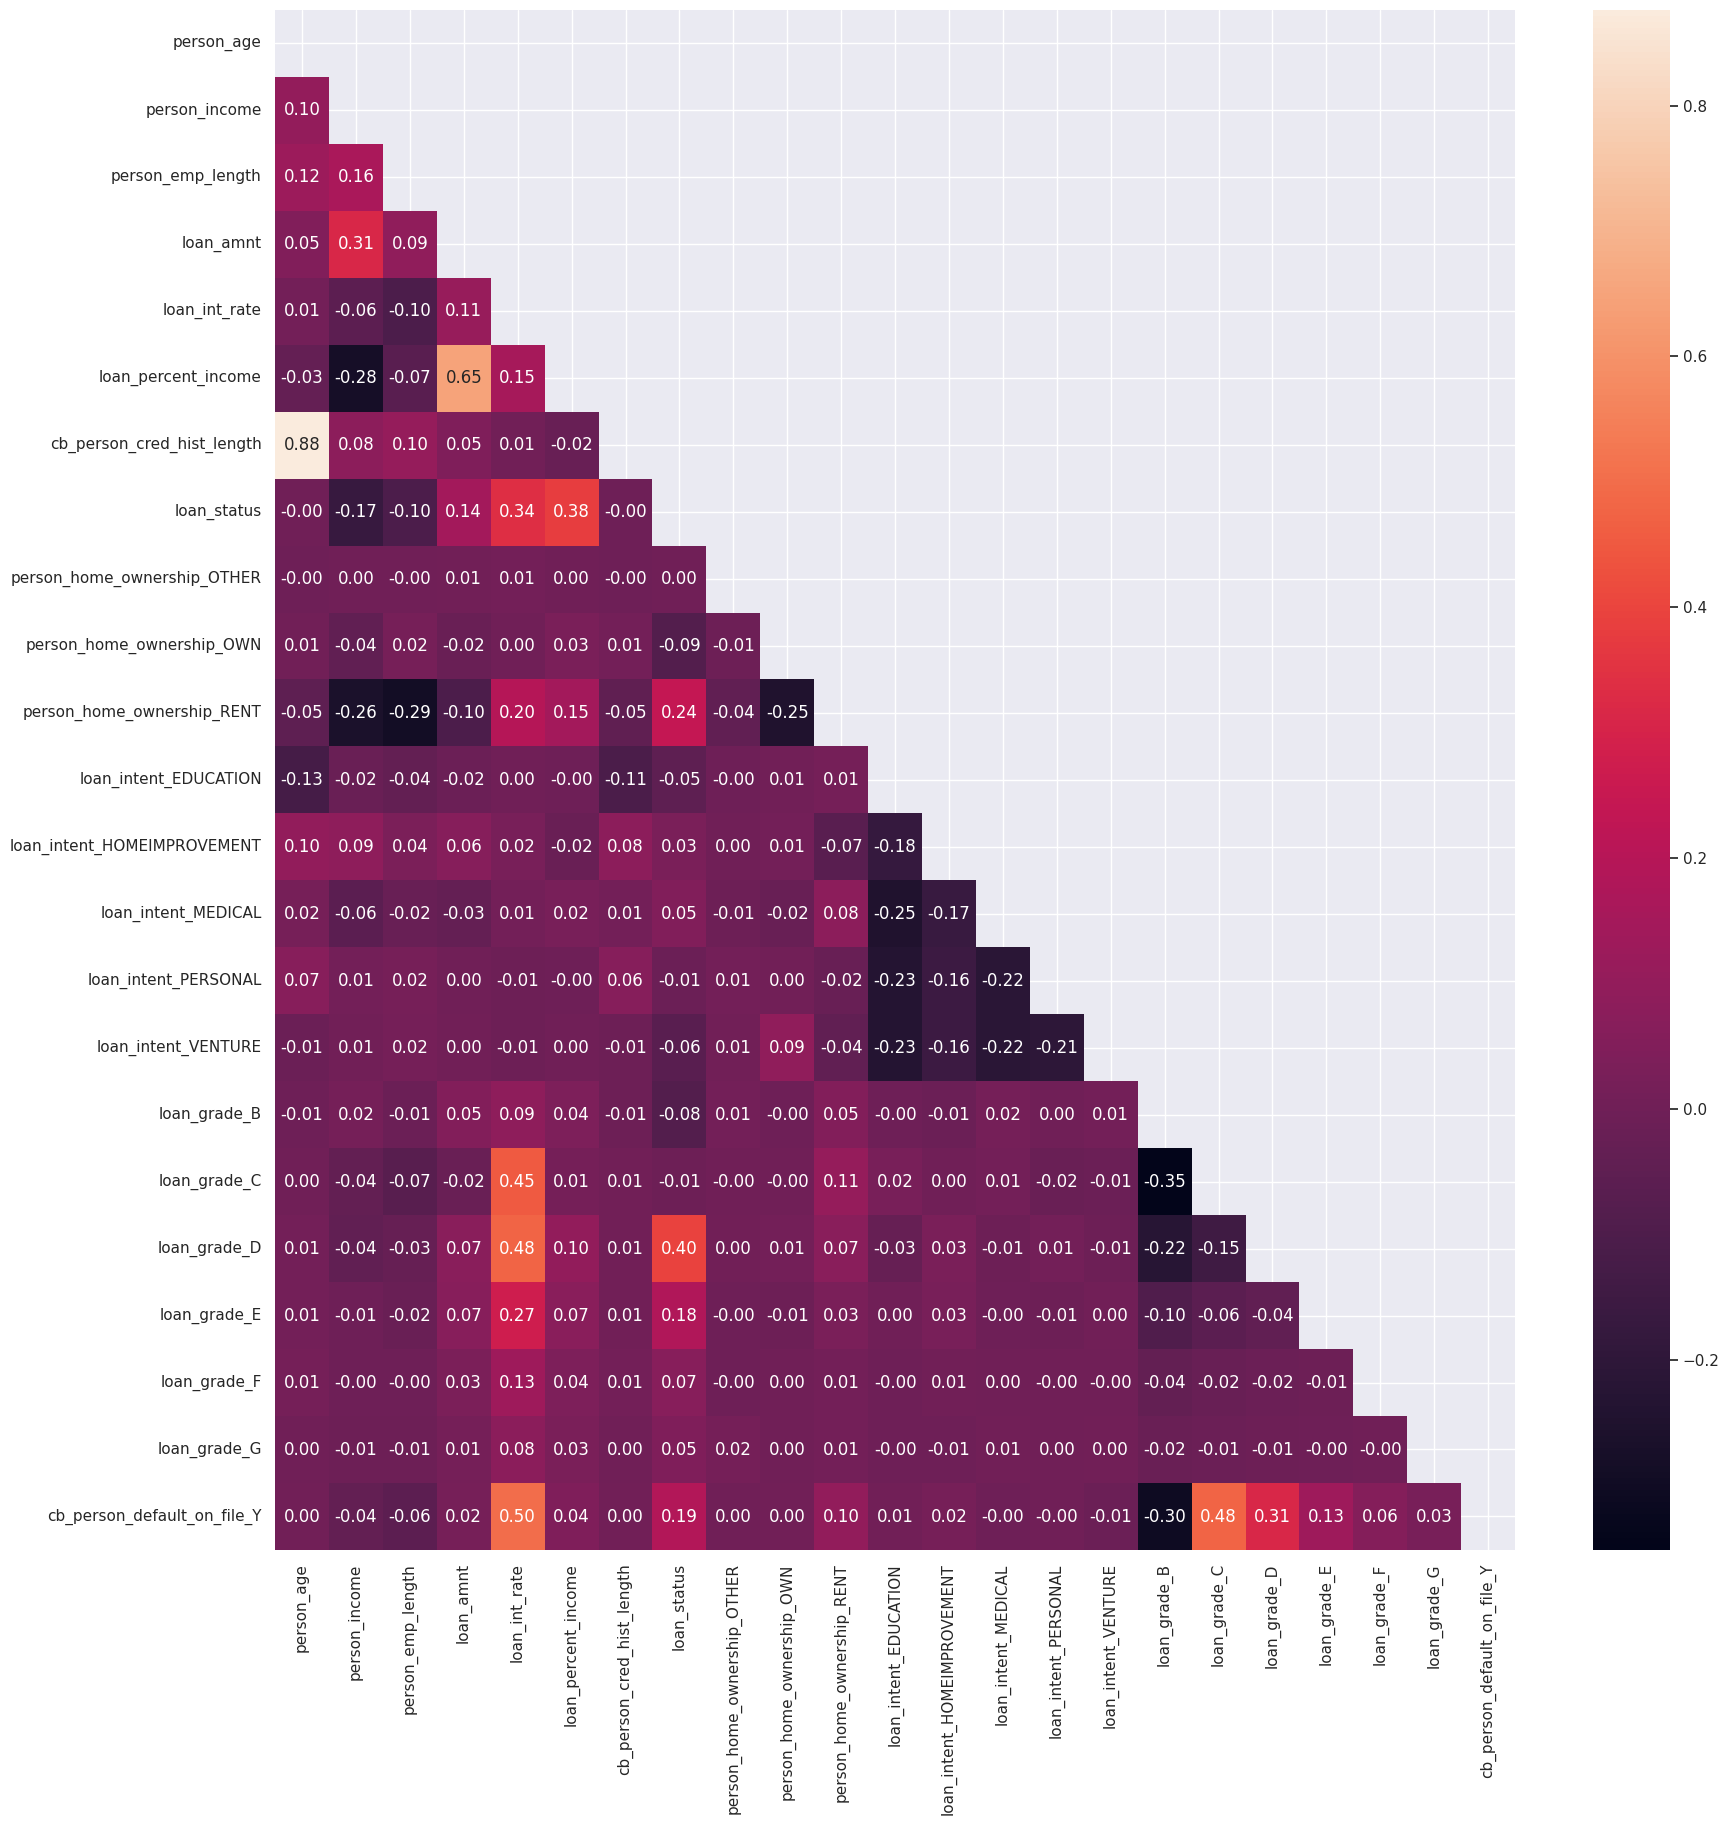

In [32]:
correlation = train.corr()
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation, annot=True, mask=mask, fmt='.2f');

## <span style="color: #B58050">Split data in X and y

In [33]:
X = train.drop(columns=['loan_status'], axis=1)
y = train['loan_status']

## <span style="color: #B58050">Train three different models which are ighly sensitive to outliers: Logistic Regression, SVM (Support Vector Machines) and KNN (K-Nearest Neighbors)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # SVM classifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
log_reg = LogisticRegression(penalty='l2', random_state=27)
svm = SVC()
knn = KNeighborsClassifier()

## <span style="color: #B58050">Train models with Optuna and boostings

In [36]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler

In [37]:
# %%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'eval_metric': 'mlogloss',
#         'use_label_encoder': False,
#         'random_state': 27
#     }
    
#     model = XGBClassifier(**params)
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
#     cv_scores = []

#     for train_index, val_index in skf.split(X_train, y_train):
#         X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         model.fit(X_cv_train, y_cv_train)
#         y_cv_pred = model.predict(X_cv_val)
#         score = roc_auc_score(y_cv_val, y_cv_pred)
#         cv_scores.append(score)

#     return np.mean(cv_scores)

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=40)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
    
"""
Number of finished trials:  40
Best trial:
  Value:  0.8615368395007937
  Params: 
    max_depth: 40
    learning_rate: 0.2174462987892294
    n_estimators: 534
    min_child_weight: 3
    gamma: 5.976300713037911e-05
    subsample: 0.6102333929129401
    colsample_bytree: 0.612352741673944
    reg_alpha: 0.799299665502581
    reg_lambda: 0.00736488994946281
CPU times: user 41min 50s, sys: 16.7 s, total: 42min 7s
Wall time: 10min 53s
"""

'\nNumber of finished trials:  40\nBest trial:\n  Value:  0.8615368395007937\n  Params: \n    max_depth: 40\n    learning_rate: 0.2174462987892294\n    n_estimators: 534\n    min_child_weight: 3\n    gamma: 5.976300713037911e-05\n    subsample: 0.6102333929129401\n    colsample_bytree: 0.612352741673944\n    reg_alpha: 0.799299665502581\n    reg_lambda: 0.00736488994946281\nCPU times: user 41min 50s, sys: 16.7 s, total: 42min 7s\nWall time: 10min 53s\n'

![](https://wiseloan.com/wp-content/uploads/2022/05/approved-loan-application.jpg)

In [38]:
# best_parameters = trial.params.items()
# best_parameters

In [39]:
model = XGBClassifier(
    max_depth = 40,
    learning_rate = 0.2174462987892294,
    n_estimators = 534,
    min_child_weight = 3,
    gamma = 5.976300713037911e-05,
    subsample = 0.6102333929129401,
    colsample_bytree = 0.612352741673944,
    reg_alpha = 0.799299665502581,
    reg_lambda = 0.00736488994946281,
    random_state = 27,
)

model.fit(X, y)
y_pred = model.predict_proba(test)

In [40]:
len(y_pred[:, 1])

39098

In [41]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [42]:
submission['loan_status'] = y_pred[:, 1]
submission.head()

,id,loan_status
0,58645,0.999700
1,58646,0.011621
2,58647,0.970231
3,58648,0.001191
4,58649,0.031859
